In [19]:
import polars as pl
import polars.selectors as cs
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import os
import sys
import polars as pl
import numpy as np

import matplotlib.pyplot as plt

PROJECT_PATH = os.path.abspath(os.path.join("..", ".."))
PIPELINE_PATH = os.path.join(PROJECT_PATH, "pipeline")
DATA_DIRECTORY = os.path.join(PROJECT_PATH, "data")

if PIPELINE_PATH not in sys.path:
    sys.path.append(PIPELINE_PATH)
    
filter = '1h'

In [35]:
df = pl.read_parquet(os.path.join(DATA_DIRECTORY, "output", "side-by-side", "1_min_sbs_period_acropolis.parquet")) \
    .with_columns(diff = pl.col("gmp343_corrected") - pl.col("picarro_corrected")) \
    .group_by_dynamic("datetime", every=filter, group_by=["system_id", "system_name"]) \
            .agg(cs.numeric().mean())

In [36]:
df = df.filter(pl.col("gmp343_temperature") > 32)

In [37]:
system_ids = df["system_id"].unique().to_list()
system_ids

[2, 4, 6, 7, 9, 11, 14, 15, 17, 19]

In [38]:
def plot_scatter_with_trendline(df, x_col_name, y_col_name="diff", max_col=5, max_row=4, x_title="x_name", y_title="ACROPOLIS - Picarro (ppm)", title_text="title_name"):
    system_ids = df.select("system_id").unique().to_series().sort().to_list()
    num_systems = len(system_ids)
    
    fig, axes = plt.subplots(max_row, max_col, figsize=(5 * max_col, 5 * max_row), sharey=True)
    fig.suptitle(title_text, fontsize=16)
    
    axes = np.array(axes).reshape(max_row, max_col)  # Ensure correct shape
    
    for idx, system_id in enumerate(system_ids):
        if idx >= max_row * max_col:
            break
        row, col = divmod(idx, max_col)
        
        ax = axes[row, col]
        df_plot = df.filter(pl.col("system_id") == system_id)
        
        x = df_plot.select(x_col_name).to_numpy().flatten().reshape(-1, 1)
        y = df_plot.select(y_col_name).to_numpy().flatten().reshape(-1, 1)
        
        # Scatter plot
        ax.scatter(x, y, label=f"MC-{int(system_id)}", alpha=0.5)
        
        # Fit linear regression
        if len(x) > 1:
            model = LinearRegression()
            model.fit(x, y)
            y_pred = model.predict(x)
            r2 = r2_score(y, y_pred)
            
            # Plot trendline
            ax.plot(x, y_pred, color='red', label=f"Trendline (R²={r2:.2f})")
        
        ax.set_title(f"System: {int(system_id)}")
        ax.set_xlabel(x_title)
        ax.set_ylabel(y_title)
        ax.legend()
    
    # Hide unused subplots
    for idx in range(num_systems, max_row * max_col):
        row, col = divmod(idx, max_col)
        fig.delaxes(axes[row, col])
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

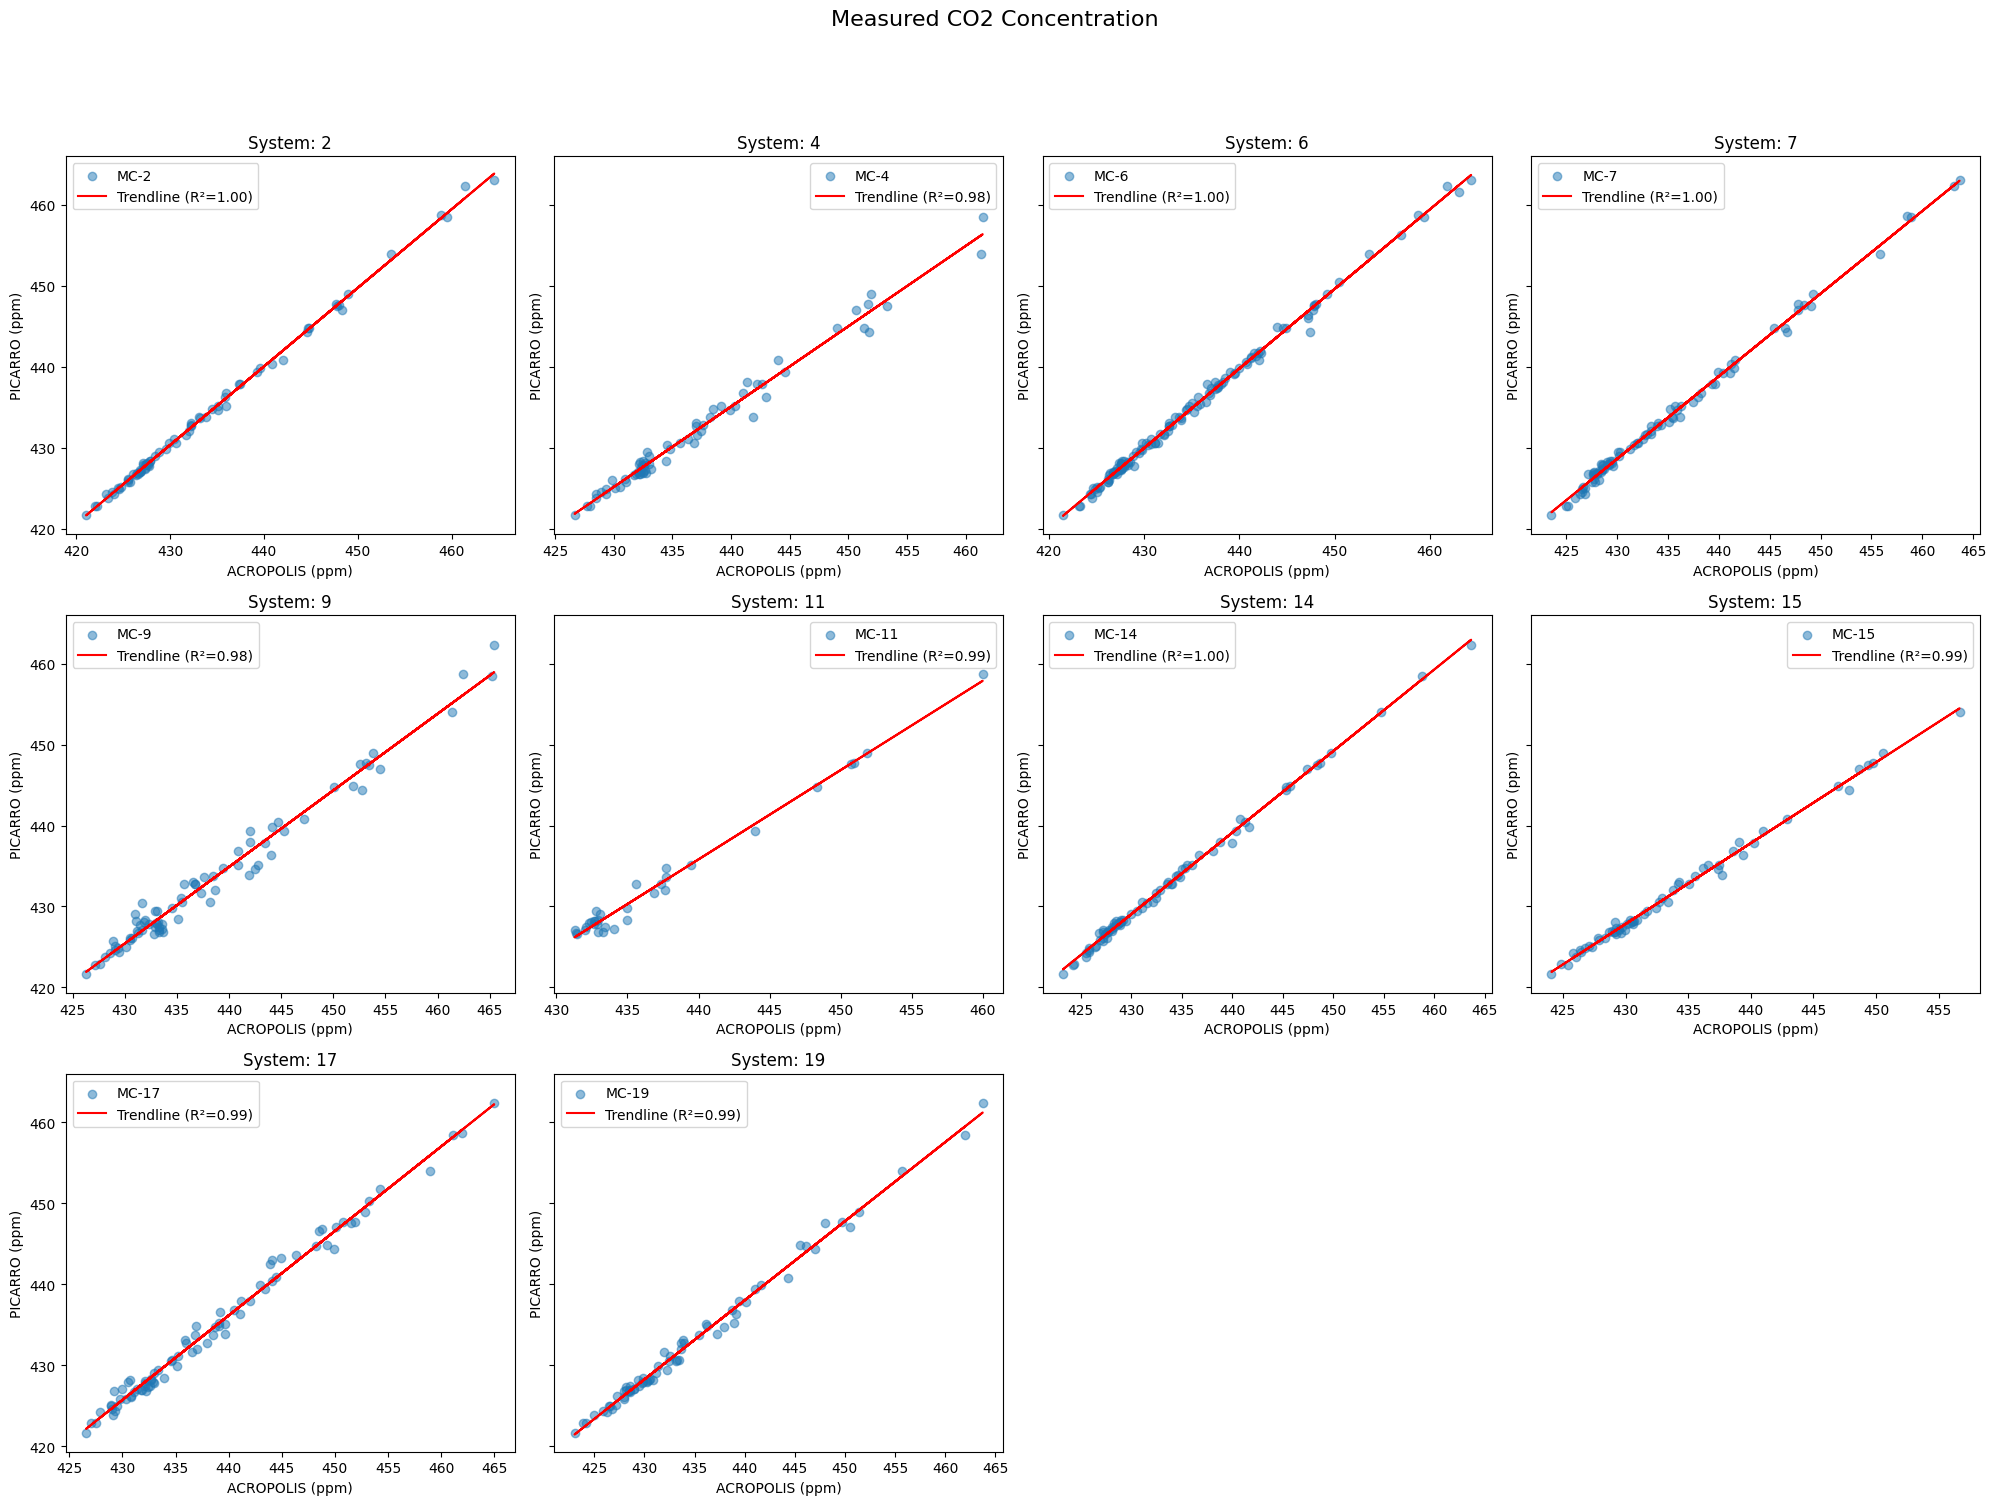

In [39]:
# parameters
x_col_name = "gmp343_corrected"
y_col_name = "picarro_corrected"
max_col = 4
max_row = 5
x_title = "ACROPOLIS (ppm)"
y_title = "PICARRO (ppm)"
title_text = "Measured CO2 Concentration" 

plot_scatter_with_trendline(df=df, x_col_name=x_col_name,y_col_name=y_col_name, max_col=max_col, max_row=max_row, x_title=x_title, y_title = y_title, title_text=title_text)

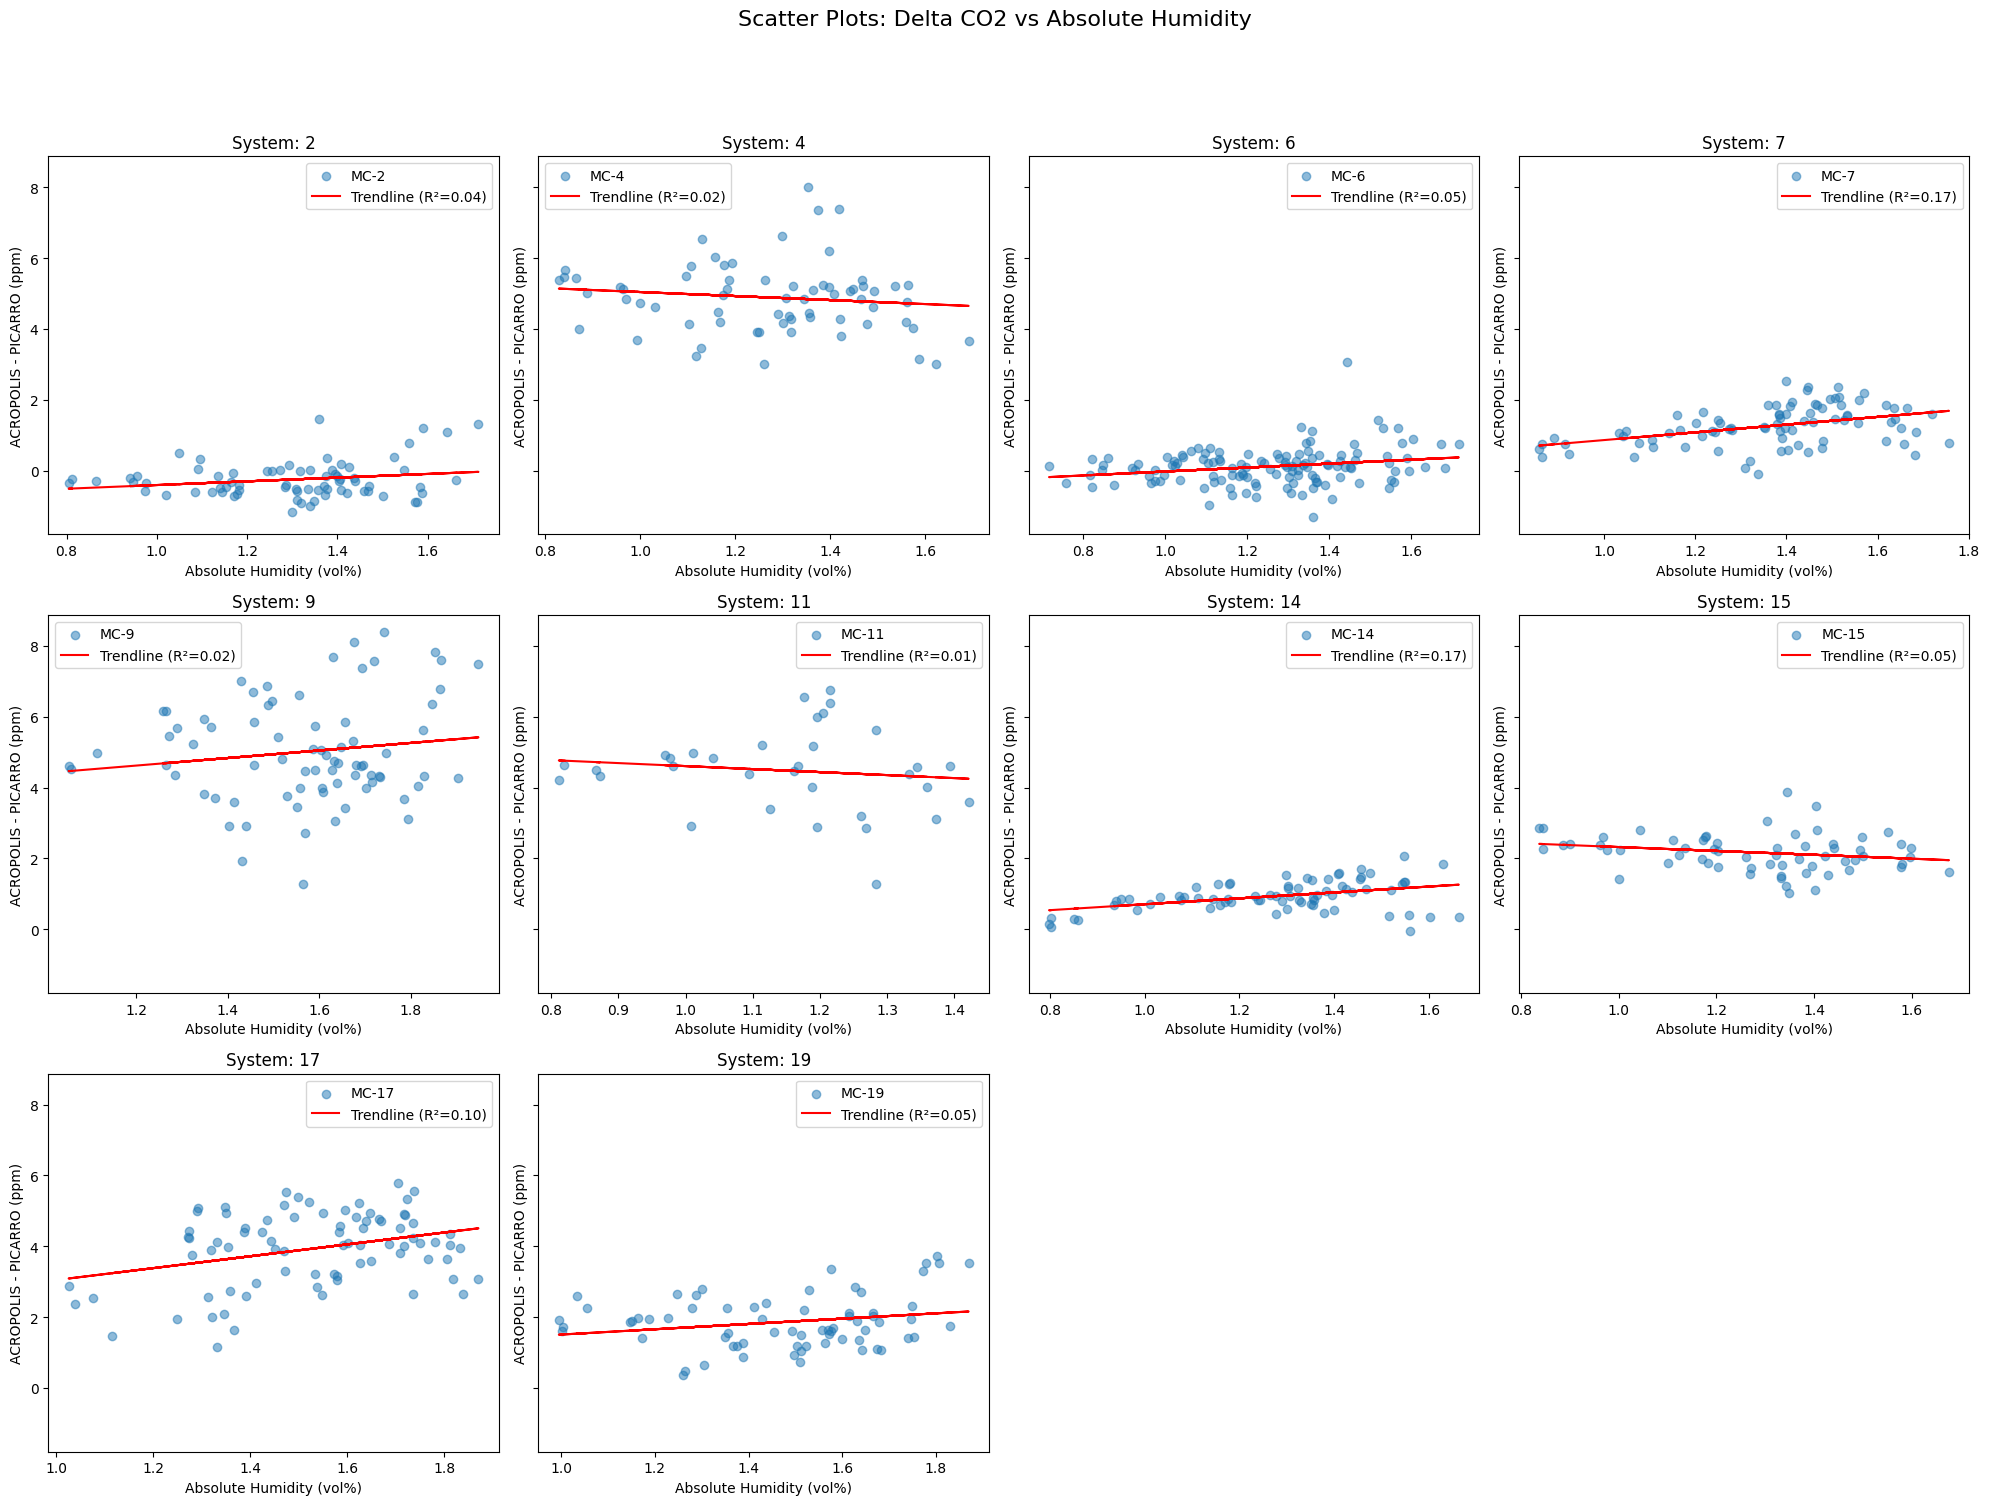

In [40]:
# parameters
x_col_name = "h2o_v%"
y_col_name = "diff"
max_col = 4
max_row = 5
x_title = "Absolute Humidity (vol%)"
y_title = "ACROPOLIS - PICARRO (ppm)"
title_text = "Scatter Plots: Delta CO2 vs Absolute Humidity" 

plot_scatter_with_trendline(df=df, x_col_name=x_col_name,y_col_name=y_col_name, max_col=max_col, max_row=max_row, x_title=x_title, y_title = y_title, title_text=title_text)

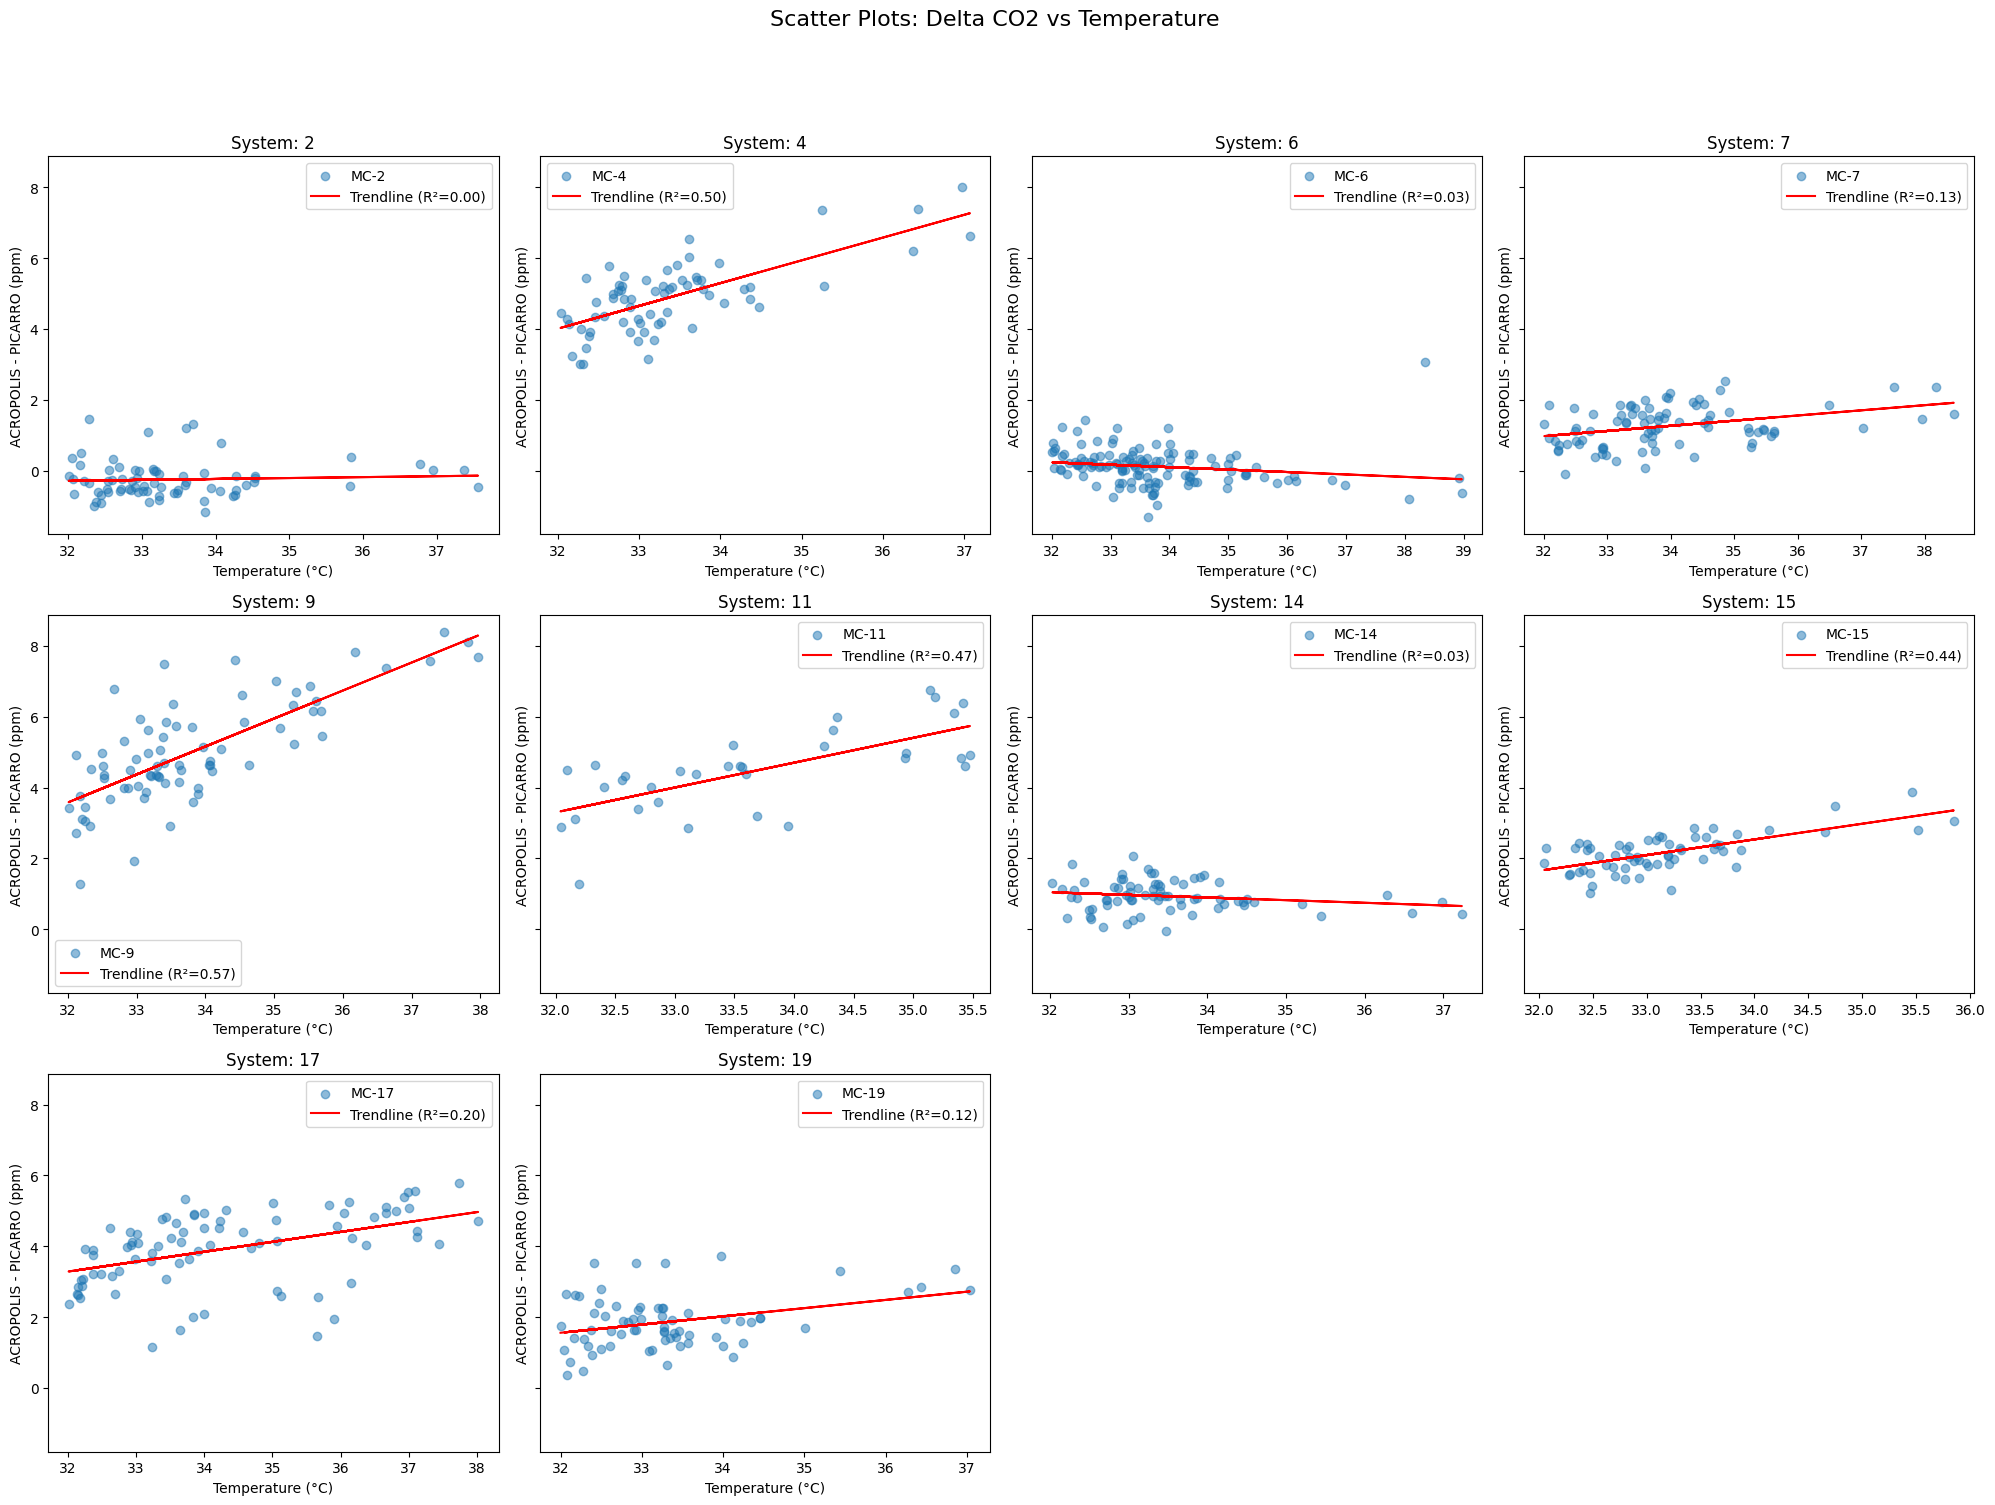

In [41]:
# parameters
x_col_name = "gmp343_temperature"
y_col_name = "diff"
max_col = 4
max_row = 5
y_title = "ACROPOLIS - PICARRO (ppm)"
x_title = "Temperature (°C)"
title_text = "Scatter Plots: Delta CO2 vs Temperature" 

plot_scatter_with_trendline(df=df, x_col_name=x_col_name,y_col_name=y_col_name, max_col=max_col, max_row=max_row, x_title=x_title, y_title = y_title, title_text=title_text)

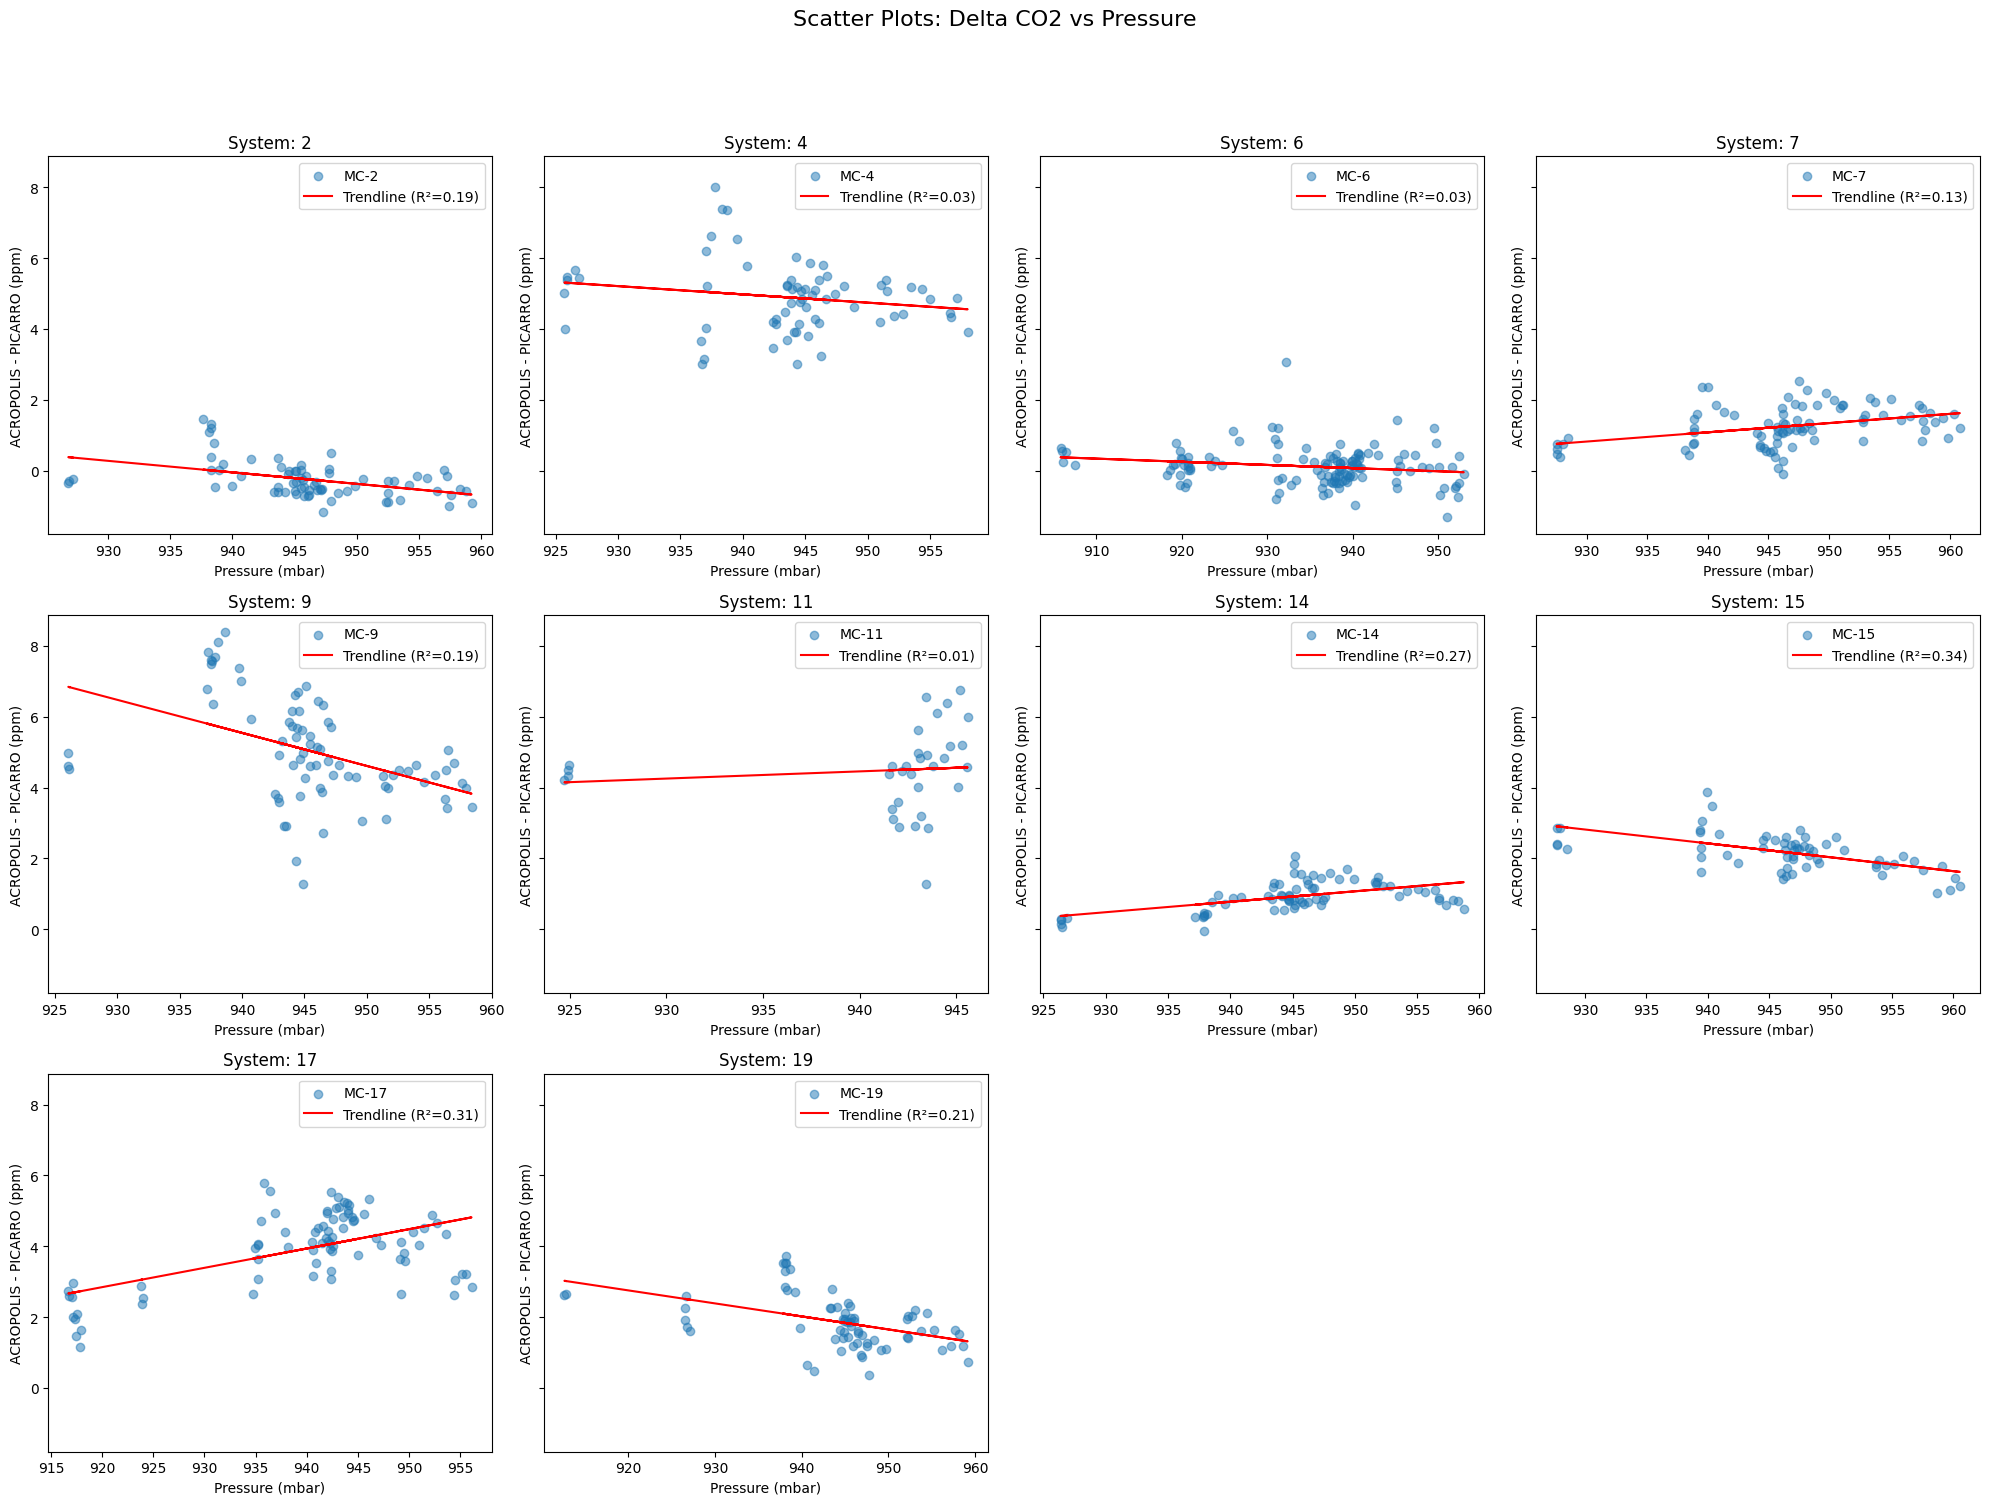

In [42]:
# parameters
x_col_name = "bme280_pressure"
y_col_name = "diff"
max_col = 4
max_row = 5
y_title = "ACROPOLIS - PICARRO (ppm)"
x_title = "Pressure (mbar)"
title_text = "Scatter Plots: Delta CO2 vs Pressure" 

plot_scatter_with_trendline(df=df, x_col_name=x_col_name,y_col_name=y_col_name, max_col=max_col, max_row=max_row, x_title=x_title, y_title = y_title, title_text=title_text)